# Milestone 3

El objetivo de este *milestone* es calcular la extrapolación de Richardson y estimar el ratio de convergencia de los esquemas temporales dados.  
Para ello, se resuelve el mismo problema de Cauchy para distintos valores de $\Delta t$ para un mismo intervalo de tiempo y órbita y se calcula

$$
E_i^{n} = \| U_i^{n} - U_{\text{ref}}^{n} \|
$$

para el $\Delta t_i$ correspondiente.

La extrapolación de Richardson viene dada por:

$$
R = \frac{E^{n}}{1 - \frac{1}{2^q}}
$$

donde $q$ es el orden del método numérico.  
Para estimar este orden, se puede usar la expresión:

$$
q \approx \frac{\log{\left( \frac{E_i}{E_j} \right)}}{\log{\left( \frac{\Delta t_i}{\Delta t_j} \right)}}
$$

Los métodos numéricos de *milestones* anteriores se encuentran en `temporal_schemes.py` y `differential_equation.py`. Al final de este notebook se muestra un plot de la extrapolación de Richardson valor aproximado de $q$ respecto al número de pasos de tiempo para todos los métodos numéricos de las *milestones* anteriores. Se ve como las pendientes en escala logarítmica de la aproximación de Richardson están relacionadas con el orden del esquema temporal.

In [1]:
from numpy import array, concatenate, zeros, linspace, log
from numpy.linalg import norm, solve, LinAlgError
import matplotlib.pyplot as plt
from temporal_schemes import Cauchy_problem, Euler, Crank_Nicolson, RK4, Inverse_Euler
from differential_equation import F

In [2]:
def richardson_extrapolation(F, U0, t1, temporal_scheme, **kwargs):
    N1 = len(t1)
    t2 = linspace(t1[0], t1[-1], 2*(N1-1)-1)
    U_1 = Cauchy_problem(F, U0, t1, temporal_scheme, **kwargs)
    U_2 = Cauchy_problem(F, U0, t2, temporal_scheme, **kwargs)
    N2 = len(t2)

    if temporal_scheme == Euler:
        q = 1
    elif temporal_scheme == Crank_Nicolson:
        q = 2
    elif temporal_scheme == RK4:
        q = 4
    elif temporal_scheme == Inverse_Euler:
        q = 1
    else:
        print("ERROR: Temporal scheme not available.")
        return -1
    error = norm(U_1[N1-1,:]-U_2[N2-1,:])/(1-1/2**q)
    return error

In [6]:
def convergence_rate(F, U0, t1, temporal_scheme, **kwargs):
    N1 = len(t1)
    t2 = linspace(t1[0], t1[-1], 2*(N1-1)+1)
    t3 = linspace(t1[0], t1[-1], 4*(N1-1)+1)
    tref = linspace(t1[0], t1[-1], 20*(N1-1)+1)
    U_1 = Cauchy_problem(F, U0, t1, temporal_scheme, **kwargs)
    U_2 = Cauchy_problem(F, U0, t2, temporal_scheme, **kwargs)
    U_3 = Cauchy_problem(F, U0, t3, temporal_scheme, **kwargs)
    U_ref = Cauchy_problem(F, U0, tref, temporal_scheme, **kwargs)
    E_1 = norm(U_1[-1,:]-U_ref[-1,:])
    E_2 = norm(U_2[-1,:]-U_ref[-1,:])
    E_3 = norm(U_3[-1,:]-U_ref[-1,:])
    delta_t1 = (t1[1]-t1[0])
    delta_t2 = t2[1]-t2[0]
    delta_t3 = t3[1]-t3[0]
    p_12 = log(E_1/E_2)/log(delta_t1/delta_t2)
    p_23 = log(E_2/E_3)/log(delta_t2/delta_t3)
    return (p_12+p_23)/2

p12: 0.42204541170709414, p23: 0.3493854038401756
p12: 4.829235336898119, p23: 4.6073414811489375
p12: -1.9764888343278864, p23: 0.9939309679471903
p12: 1.9647273259228792, p23: 2.0330734930319783
p12: 0.8337555040427292, p23: 1.042352551716991
p12: 4.072733427732789, p23: 4.035979446235447
p12: 0.8925910586769303, p23: 1.2842188131984174
p12: 2.0108605087323372, p23: 2.044387163702775
p12: 0.9463019693407149, p23: 1.1032714932927201
p12: 4.035710641422377, p23: 3.892081273846455
p12: 1.1880898990639392, p23: 1.2358022674255782
p12: 2.0108811351693543, p23: 2.0443922340211556
p12: 0.988346542235733, p23: 1.1249605879043594
p12: 4.14362810886344, p23: 5.586478545137729
p12: 1.161891706972887, p23: 1.2147386396627324
p12: 2.0108850573887525, p23: 2.044393187258688
p12: 1.0101906720746279, p23: 1.1360299568805616
p12: 4.084838225094899, p23: 4.112830511163669
p12: 1.1432577431988942, p23: 1.2037731846080995
p12: 2.0108865073516458, p23: 2.044392848198866


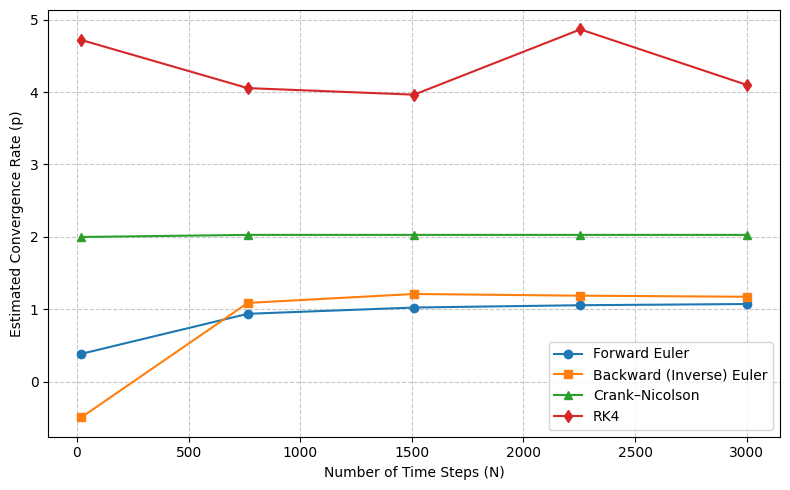

In [7]:
U0 = array([1, 0, 0, 1])
T = 10
N_0 = 20
N_F = 3000
N_N = 5
N_arr = linspace(N_0, N_F, N_N)

conv_rate_euler = zeros(N_N)
conv_rate_rk4 = zeros(N_N)
conv_rate_inv_euler = zeros(N_N)
conv_rate_crank_nicholson = zeros(N_N)

for i, N in enumerate(N_arr):
    t1 = linspace(0, T, int(N))
    conv_rate_euler[i] = convergence_rate(F, U0, t1, Euler)
    conv_rate_rk4[i] = convergence_rate(F, U0, t1, RK4)
    conv_rate_inv_euler[i] = convergence_rate(F, U0, t1, Inverse_Euler, tol_jacobian=1e-9, N_max=10000, newton_tol=1e-9)
    conv_rate_crank_nicholson[i] = convergence_rate(F, U0, t1, Crank_Nicolson, tol_jacobian=1e-9, N_max=10000, newton_tol=1e-9)

plt.figure(figsize=(8,5))
plt.plot(N_arr, conv_rate_euler, 'o-', label='Forward Euler')
plt.plot(N_arr, conv_rate_inv_euler, 's-', label='Backward (Inverse) Euler')
plt.plot(N_arr, conv_rate_crank_nicholson, '^-', label='Crank–Nicolson')
plt.plot(N_arr, conv_rate_rk4, 'd-', label='RK4')
plt.grid(True, which='both', ls='--', alpha=0.7)
plt.xlabel('Number of Time Steps (N)')
plt.ylabel('Estimated Convergence Rate (p)')
plt.legend()
plt.tight_layout()
plt.show()

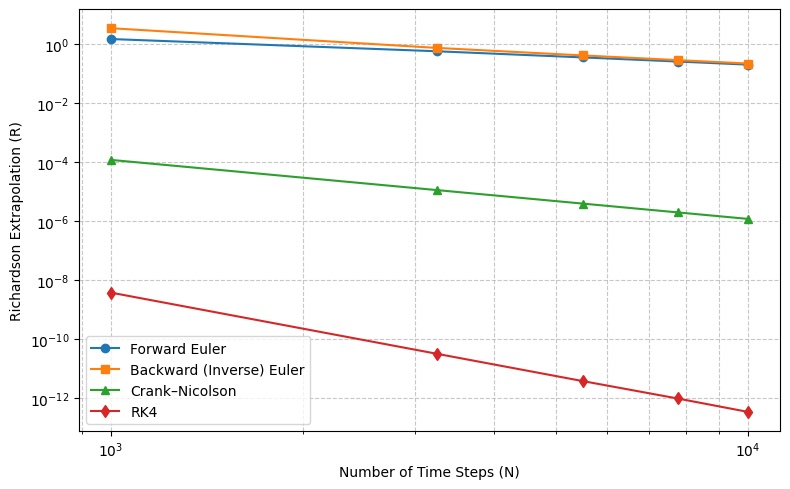

In [11]:
U0 = array([1, 0, 0, 1])
T = 10
N_0 = 1000
N_F = 10000
N_N = 5
N_arr = linspace(N_0, N_F, N_N)

error_euler = zeros(N_N)
error_rk4 = zeros(N_N)
error_inv_euler = zeros(N_N)
error_crank_nicholson = zeros(N_N)

for i, N in enumerate(N_arr):
    t1 = linspace(0, T, int(N))
    error_euler[i] = richardson_extrapolation(F, U0, t1, Euler)
    error_rk4[i] = richardson_extrapolation(F, U0, t1, RK4)
    error_inv_euler[i] = richardson_extrapolation(F, U0, t1, Inverse_Euler, tol_jacobian=1e-9, N_max=10000, newton_tol=1e-9)
    error_crank_nicholson[i] = richardson_extrapolation(F, U0, t1, Crank_Nicolson, tol_jacobian=1e-9, N_max=10000, newton_tol=1e-9)

plt.figure(figsize=(8,5))
plt.plot(N_arr, error_euler, 'o-', label='Forward Euler')
plt.plot(N_arr, error_inv_euler, 's-', label='Backward (Inverse) Euler')
plt.plot(N_arr, error_crank_nicholson, '^-', label='Crank–Nicolson')
plt.plot(N_arr, error_rk4, 'd-', label='RK4')
plt.grid(True, which='both', ls='--', alpha=0.7)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Number of Time Steps (N)')
plt.ylabel('Richardson Extrapolation (R)')
plt.legend()
plt.tight_layout()
plt.show()